# TODO
- remove reliance on rrow, like audio constants dict
- make into functions better
- show pinyin on top of character

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# !pip install gtts pydub audioop-lts
import time
import os
import pandas as pd
from collections import defaultdict
from PIL import Image, ImageDraw, ImageFont
from moviepy import ImageClip
from utils_data import (
    load_raw_data, check_dups, filter_df_to_vocab_of_interest, 
    fill_default_settings, delete_previous_attempt_files
    )
from utils_video import (
    combine_clips_with_audio_to_create_video, create_icon_from_slide,
    draw_word_index, draw_logo, draw_previous_word, draw_previous_sent,
    draw_vocab_based_on_format, generate_intro_slide,
    generate_word_list_slide, generate_outro_slide
)
from utils_audio import (
    create_tts_files_for_one_vocab_word, compute_pinyin_and_create_recordings,
    combine_audio_files_and_compute_durations,
    generate_nonvocab_audio_and_compute_durations, create_final_audio_from_each_word_and_nonvocab
)
from configs.v007_apps import (
    data_settings, output_path,
    video_configs, icon_configs,
    nonvocab_slides, subtitle_text_configs,
    DEFAULT_TEXT_PROPERTIES,
)
subtitle_text_configs['font'] = ImageFont.truetype(subtitle_text_configs['font_name'], subtitle_text_configs['font_size'])
pd.options.display.max_columns = 100
pd.options.display.max_rows = 130

In [3]:
truly_load_data = True
to_delete = True

# 0. Create dataframe of settings

In [4]:
# Create settings df
data_settings = fill_default_settings(data_settings)
rrow = data_settings

# Create folder for non-audio recordings for this project
project_artifacts_folder = f"{output_path}/{data_settings['recording_name']}"

# Create folder if not exists, and delete previous files if desired
if not os.path.exists(project_artifacts_folder):
    os.mkdir(project_artifacts_folder)
if to_delete:
    delete_previous_attempt_files(project_artifacts_folder)
data_settings

{'recording_id': 'ceword_components_csent',
 'filename_suffix': 'app_names',
 'min_combo_quality': 5,
 'categories2_allowed': ['app'],
 'types_allowed': ['combo',
  'no combo',
  'two word',
  'prefix',
  'single char',
  'suffix',
  'abbreviation',
  'phrase',
  'part sent',
  'phrase_save',
  'speak_phrase',
  'saying',
  'idiom',
  'slang',
  'signs',
  'signs_uncommon',
  'sentence',
  'proper noun',
  'idiom'],
 'min_priority': 1,
 'max_priority': 4,
 'min_known_english_prompt': 1,
 'max_known_english_prompt': 6,
 'min_known_pinyin_prompt': 1,
 'max_known_pinyin_prompt': 6,
 'sort_keys': ['category1', 'category2', 'pinyin'],
 'sort_asc': [True, True, True],
 'categories_allowed': None,
 'cat1_values_allowed': None,
 'types_allowed_str': '',
 'min_adu': 1,
 'min_per': 1,
 'min_date': '2025-01-01',
 'contains_character': None,
 'exclude_words': None,
 'max_count': 1000000,
 'recording_name': '0929_ceword_components_csent_app_names'}

# 1. Load data

In [5]:
if truly_load_data:
    df_all_vocab = load_raw_data()
    df_all_vocab.to_csv('latest_data.csv', index=False)
else:
    df_all_vocab = pd.read_csv('latest_data.csv')
    print('!!!!!!!! WARNING: not truly loading data !!!!!!!!')

df_dups = check_dups(df_all_vocab)
print(f'# duplicate vocab: {len(df_dups)}')
print(df_all_vocab.shape)
df_all_vocab.head(3)

# duplicate vocab: 0
(5434, 28)


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,1,房贷,fáng dài,mortgage,combo,1.0,1.0,1.0,2.0,NaN,life,NaN,1.0,房,house,贷,loan,NaN,NaN,NaN,NaN,他每个月都要还房贷,Ta měi gè yuè dōu yào huán fángdài,He has to pay his mortgage every month,2025-01-02,NaN,5.0,5.0
1,2,白天,bái tiān,daytime,combo,2.0,2.0,1.0,1.0,NaN,time,NaN,1.0,白,white,天,day,NaN,NaN,NaN,NaN,白天很热晚上比较凉快,Báitiān hěn rè wǎnshàng bǐjiào liángkuai,It is hot in the daytime and cooler at night,2025-01-02,NaN,5.0,5.0
2,3,组成,zǔ chéng,to form;make up,combo,3.0,5.0,5.0,5.0,NaN,general,NaN,3.0,组,set,成,become,NaN,NaN,NaN,NaN,水是由氢和氧组成的,Shuǐ shì yóu qīng hé yǎng zǔchéng de,Water is made up of hydrogen and oxygen,2025-01-02,NaN,5.0,5.0


# 2. Select data

In [6]:
df_vocab_lists = filter_df_to_vocab_of_interest(df_all_vocab, data_settings)
n_vocab = len(df_vocab_lists)
print(data_settings['recording_name'], n_vocab)
df_vocab_lists.head(3)

0929_ceword_components_csent_app_names 21


,id,chinese,pinyin,english,type,priority,known,known_pinyin_prompt,known_english_prompt,phonetic,category1,category2,quality,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,sentence,sentence_pinyin,sentence_english,date,cat1,per,adu
0,5405,百度,bǎi dù,Chinese Google Search,proper noun,2.0,1.0,1.0,5.0,NaN,electronics,app,4.0,百,hundred,度,degree,NaN,NaN,NaN,NaN,她在百度搜索猫咪照片,tā zài bǎidù sōusuǒ māomī zhàopiàn,She searched for cat photos on Baidu,2025-09-27,daily add,5.0,5.0
1,5401,大众点评,dà zhòng diǎn píng,Chinese Yelp,proper noun,1.0,1.0,1.0,5.0,NaN,electronics,app,4.0,大众,the masses,点评,point by point commentary,NaN,NaN,NaN,NaN,我们在大众点评上找了一家猫咖,wǒmen zài dàzhòng diǎnpíng shàng zhǎol...,We found a cat café on Dianping,2025-09-27,daily add,5.0,5.0
2,5395,滴滴,dī dī,Chinese Uber,proper noun,1.0,2.0,2.0,5.0,NaN,electronics,app,4.0,滴,drip,滴,drip,NaN,NaN,NaN,NaN,他用滴滴打车去公司,tā yòng dīdī dǎchē qù gōngsī,He used Didi to get a ride to the office,2025-09-27,daily add,5.0,5.0


# 3. Create vocabulary audio recordings

In [7]:
if data_settings['recording_id'] == '005':
    df_vocab_lists = compute_pinyin_and_create_recordings(df_vocab_lists)

start_time = time.time()
for i_row, row in df_vocab_lists.iterrows():
    print(f"{(time.time()-start_time):.1f}s, row{i_row}")
    create_tts_files_for_one_vocab_word(row, rrow)

0.0s, row0
0.000s, ALREADY EXISTS, zh, 百度
0.000s, ALREADY EXISTS, zh_slow, 百度
0.000s, ALREADY EXISTS, english, Chinese Google Search
0.000s, ALREADY EXISTS, zh, 她在百度搜索猫咪照片
0.000s, ALREADY EXISTS, english, She searched for cat photos on Baidu
0.000s, ALREADY EXISTS, zh, 百
0.000s, ALREADY EXISTS, zh, 度
0.000s, ALREADY EXISTS, english, hundred
0.000s, ALREADY EXISTS, english, degree
0.0s, row1
0.000s, ALREADY EXISTS, zh, 大众点评
0.000s, ALREADY EXISTS, zh_slow, 大众点评
0.000s, ALREADY EXISTS, english, Chinese Yelp
0.000s, ALREADY EXISTS, zh, 我们在大众点评上找了一家猫咖
0.000s, ALREADY EXISTS, english, We found a cat café on Dianping
0.000s, ALREADY EXISTS, zh, 大众
0.000s, ALREADY EXISTS, zh, 点评
0.000s, ALREADY EXISTS, english, the masses
0.000s, ALREADY EXISTS, english, point by point commentary
0.0s, row2
0.000s, ALREADY EXISTS, zh, 滴滴
0.000s, ALREADY EXISTS, zh_slow, 滴滴
0.000s, ALREADY EXISTS, english, Chinese Uber
0.000s, ALREADY EXISTS, zh, 他用滴滴打车去公司
0.000s, ALREADY EXISTS, english, He used Didi to get a

## 3b. Compute durations of combined audios for each vocab word

In [8]:
audio_duration_file_name = f"{project_artifacts_folder}/audio_durations_vocab_only.csv"
if os.path.exists(audio_duration_file_name):
    df_vocab_audio_durations = pd.read_csv(audio_duration_file_name)
    print(f"Loaded existing audio durations for {rrow['recording_name']}, shape {df_vocab_audio_durations.shape}")
else:
    df_vocab_audio_durations = combine_audio_files_and_compute_durations(df_vocab_lists, rrow)
    df_vocab_audio_durations.to_csv(audio_duration_file_name, index=False)

df_vocab_audio_durations['nonvocab_file_path'] = None
df_vocab_audio_durations['nonvocab_pause_ms'] = None
df_vocab_audio_durations['nonvocab_key'] = None
print(f"Total duration: {df_vocab_audio_durations['combined'].sum()}s")
df_vocab_audio_durations.head(3)

0.83 seconds, recid0929_ceword_components_csent_app_names, row 0, 百度
0.70 seconds, recid0929_ceword_components_csent_app_names, row 1, 大众点评
0.67 seconds, recid0929_ceword_components_csent_app_names, row 2, 滴滴
0.68 seconds, recid0929_ceword_components_csent_app_names, row 3, 钉钉
0.86 seconds, recid0929_ceword_components_csent_app_names, row 4, 叮咚买菜
0.74 seconds, recid0929_ceword_components_csent_app_names, row 5, 抖音
0.91 seconds, recid0929_ceword_components_csent_app_names, row 6, 高德地图
0.75 seconds, recid0929_ceword_components_csent_app_names, row 7, 盒马
1.09 seconds, recid0929_ceword_components_csent_app_names, row 8, 京东到家
0.73 seconds, recid0929_ceword_components_csent_app_names, row 9, 美团
0.75 seconds, recid0929_ceword_components_csent_app_names, row 10, 拼多多
0.79 seconds, recid0929_ceword_components_csent_app_names, row 11, 去哪儿
0.77 seconds, recid0929_ceword_components_csent_app_names, row 12, 天猫
0.75 seconds, recid0929_ceword_components_csent_app_names, row 13, 淘宝
0.75 seconds, recid0

,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,d_chinese,d_component_words,d_chinese_slow,d_english,d_sent,rel_start_chinese,rel_start_component_words,rel_start_english,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key
0,百度,bǎi dù,Chinese Google Search,她在百度搜索猫咪照片,tā zài bǎidù sōusuǒ māomī zhàopiàn,She searched for cat photos on Baidu,百,hundred,度,degree,,,,,1.104,4.179625,1.272,1.944,3.360,0,1.604,8.055625,10.499625,14.859625,14.859042,None,None,None
1,大众点评,dà zhòng diǎn píng,Chinese Yelp,我们在大众点评上找了一家猫咖,wǒmen zài dàzhòng diǎnpíng shàng zhǎol...,We found a cat café on Dianping,大众,the masses,点评,point by point commentary,,,,,1.656,6.291625,1.944,1.440,3.960,0,2.156,11.391625,13.331625,18.291625,18.291042,None,None,None
2,滴滴,dī dī,Chinese Uber,他用滴滴打车去公司,tā yòng dīdī dǎchē qù gōngsī,He used Didi to get a ride to the office,滴,drip,滴,drip,,,,,1.080,3.723625,1.224,1.512,2.976,0,1.580,7.527625,9.539625,13.515625,13.515042,None,None,None


# 4. Create non-vocab audio recordings

In [9]:
df_vocab_audio_durations, audio_filler_variables, nonvocab_slides = generate_nonvocab_audio_and_compute_durations(
    data_settings, df_vocab_audio_durations, nonvocab_slides, project_artifacts_folder)
df_vocab_audio_durations.head(10)

intro audio already generated: 欢迎观看我的普通话数据库视频 7: 中国应用: 名字解释
word_list audio already generated: 这些是将在接下来的6分钟内复习的21个单词
outro audio already generated: 如果你有任何问题、建议或反馈，请留言。请点赞并订阅。


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,d_chinese,d_component_words,d_chinese_slow,d_english,d_sent,rel_start_chinese,rel_start_component_words,rel_start_english,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_chinese,start_component_words,start_english,start_sent
0,欢迎观看我的普通话数据库视频 7: 中国应用: 名字解释,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.520000,output/videos//0929_ceword_components_csent_ap...,500,intro,8.520000,0.000000,NaN,NaN,NaN,NaN
1,这些是将在接下来的6分钟内复习的21个单词,Zhèxiē shì jiàng zài jiē xiàlái de 6 fēnzhōng ...,These are the 21 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.030000,output/videos//0929_ceword_components_csent_ap...,500,word_list,15.550000,8.520000,NaN,NaN,NaN,NaN
2,百度,bǎi dù,Chinese Google Search,她在百度搜索猫咪照片,tā zài bǎidù sōusuǒ māomī zhàopiàn,She searched for cat photos on Baidu,百,hundred,度,degree,,,,,1.104,4.179625,1.272,1.944,3.360,0.0,1.604,8.055625,10.499625,14.859625,14.859042,None,None,None,30.409042,15.550000,15.550000,17.154000,23.605625,26.049625
3,大众点评,dà zhòng diǎn píng,Chinese Yelp,我们在大众点评上找了一家猫咖,wǒmen zài dàzhòng diǎnpíng shàng zhǎol...,We found a cat café on Dianping,大众,the masses,点评,point by point commentary,,,,,1.656,6.291625,1.944,1.440,3.960,0.0,2.156,11.391625,13.331625,18.291625,18.291042,None,None,None,48.700083,30.409042,30.409042,32.565042,41.800667,43.740667
4,滴滴,dī dī,Chinese Uber,他用滴滴打车去公司,tā yòng dīdī dǎchē qù gōngsī,He used Didi to get a ride to the office,滴,drip,滴,drip,,,,,1.080,3.723625,1.224,1.512,2.976,0.0,1.580,7.527625,9.539625,13.515625,13.515042,None,None,None,62.215125,48.700083,48.700083,50.280083,56.227708,58.239708
5,钉钉,dīng dīng,Chinese Slack,公司用钉钉开了一个线上会议,gōngsī yòng dīngdīng kāile yíge xiànš...,The company held an online meeting on DingTalk,钉,nail,钉,nail,,,,,1.128,3.963625,1.296,1.464,3.888,0.0,1.628,7.887625,9.851625,14.739625,14.739042,None,None,None,76.954167,62.215125,62.215125,63.843125,70.102750,72.066750
6,叮咚买菜,dīng dōng mǎi cài,Chinese Instacart,她在叮咚买菜买了鱼和虾,tā zài dīngdōng mǎicài mǎile yú hé xiā,She bought fish and shrimp on Dingdong Maicai,叮咚,ding dong sound,买,buy,菜,food,,,1.584,7.203375,1.848,1.704,3.528,0.0,2.084,12.135375,14.339375,18.867375,18.866792,None,None,None,95.820958,76.954167,76.954167,79.038167,89.089542,91.293542
7,抖音,dǒu yīn,Chinese TikTok,她在抖音上刷到了很多小狗视频,tā zài dǒuyīn shàng shuā dào le hěnduo...,She watched many puppy videos on Douyin,颤抖,to tremble,声音,sound,,,,,1.056,4.947625,1.224,1.632,4.464,0.0,1.556,8.727625,10.859625,16.323625,16.323042,None,None,None,112.144000,95.820958,95.820958,97.376958,104.548583,106.680583
8,高德地图,gāo dé dì tú,Chinese Google Maps,我用高德地图找到宠物医院,wǒ yòng gāodé dìtú zhǎodào chǒngwù y...,I used Gaode Maps to find a pet hospital,高,high,德,virtue,地图,map,,,1.608,6.531375,1.896,1.944,3.744,0.0,2.108,11.535375,13.979375,18.723375,18.722792,None,None,None,130.866792,112.144000,112.144000,114.252000,123.679375,126.123375
9,盒马,hé mǎ,Chinese Whole Foods,我在盒马买了新鲜的三文鱼,wǒ zài hémǎ mǎile xīnxiān de sānwényú,I bought fresh salmon at Hema,盒,box,马,horse,,,,,1.128,4.419625,1.320,1.872,3.696,0.0,1.628,8.367625,10.739625,15.435625,15.435042,None,None,None,146.301833,130.866792,130.866792,132.494792,139.234417,141.606417


# 5. Combine individual vocab into final audio recording

In [10]:
create_final_audio_from_each_word_and_nonvocab(df_vocab_audio_durations, project_artifacts_folder, data_settings)

2.73s, output/videos//0929_ceword_components_csent_app_names/audio.mp3


# 6. Create images for video

In [11]:
# If don't want to rerun the above cells, then just run this cell to load the audio durations
audio_generation_previous_run = True
if audio_generation_previous_run:
    try:
        df_vocab_audio_durations = pd.read_csv(f"{project_artifacts_folder}/audio_durations_all.csv")
        print(f"{rrow['recording_name']} loaded")
    except FileNotFoundError:
        print(f"File not found for recording {rrow['recording_name']}, please run the cell above to generate audio durations.")
df_vocab_audio_durations.head()

0929_ceword_components_csent_app_names loaded


,chinese,pinyin,english,sentence,sentence_pinyin,sentence_english,word1,word1_english,word2,word2_english,word3,word3_english,word4,word4_english,d_chinese,d_component_words,d_chinese_slow,d_english,d_sent,rel_start_chinese,rel_start_component_words,rel_start_english,rel_start_sent,sum_theory,combined,nonvocab_file_path,nonvocab_pause_ms,nonvocab_key,end,start,start_chinese,start_component_words,start_english,start_sent
0,欢迎观看我的普通话数据库视频 7: 中国应用: 名字解释,Huānyíng guānkàn wǒ de pǔtōnghuà shùjùkù shìpí...,Welcome to my Mandarin Chinese Database Video ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.520000,output/videos//0929_ceword_components_csent_ap...,500.0,intro,8.520000,0.000000,NaN,NaN,NaN,NaN
1,这些是将在接下来的6分钟内复习的21个单词,Zhèxiē shì jiàng zài jiē xiàlái de 6 fēnzhōng ...,These are the 21 words that will be reviewed o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.030000,output/videos//0929_ceword_components_csent_ap...,500.0,word_list,15.550000,8.520000,NaN,NaN,NaN,NaN
2,百度,bǎi dù,Chinese Google Search,她在百度搜索猫咪照片,tā zài bǎidù sōusuǒ māomī zhàopiàn,She searched for cat photos on Baidu,百,hundred,度,degree,NaN,NaN,NaN,NaN,1.104,4.179625,1.272,1.944,3.360,0.0,1.604,8.055625,10.499625,14.859625,14.859042,NaN,NaN,NaN,30.409042,15.550000,15.550000,17.154000,23.605625,26.049625
3,大众点评,dà zhòng diǎn píng,Chinese Yelp,我们在大众点评上找了一家猫咖,wǒmen zài dàzhòng diǎnpíng shàng zhǎol...,We found a cat café on Dianping,大众,the masses,点评,point by point commentary,NaN,NaN,NaN,NaN,1.656,6.291625,1.944,1.440,3.960,0.0,2.156,11.391625,13.331625,18.291625,18.291042,NaN,NaN,NaN,48.700083,30.409042,30.409042,32.565042,41.800667,43.740667
4,滴滴,dī dī,Chinese Uber,他用滴滴打车去公司,tā yòng dīdī dǎchē qù gōngsī,He used Didi to get a ride to the office,滴,drip,滴,drip,NaN,NaN,NaN,NaN,1.080,3.723625,1.224,1.512,2.976,0.0,1.580,7.527625,9.539625,13.515625,13.515042,NaN,NaN,NaN,62.215125,48.700083,48.700083,50.280083,56.227708,58.239708


## 6a. Vocab words

Drawing 0: 百度
Drawing 1: 大众点评
Drawing 2: 滴滴
Drawing 3: 钉钉
Drawing 4: 叮咚买菜
Drawing 5: 抖音
Drawing 6: 高德地图
Drawing 7: 盒马
Drawing 8: 京东到家
Drawing 9: 美团
Drawing 10: 拼多多
Drawing 11: 去哪儿
Drawing 12: 天猫
Drawing 13: 淘宝
Drawing 14: 微博
Drawing 15: 微信
Drawing 16: 闲鱼
Drawing 17: 携程旅行
Drawing 18: 小红书
Drawing 19: 支付宝
Drawing 20: 饿了么



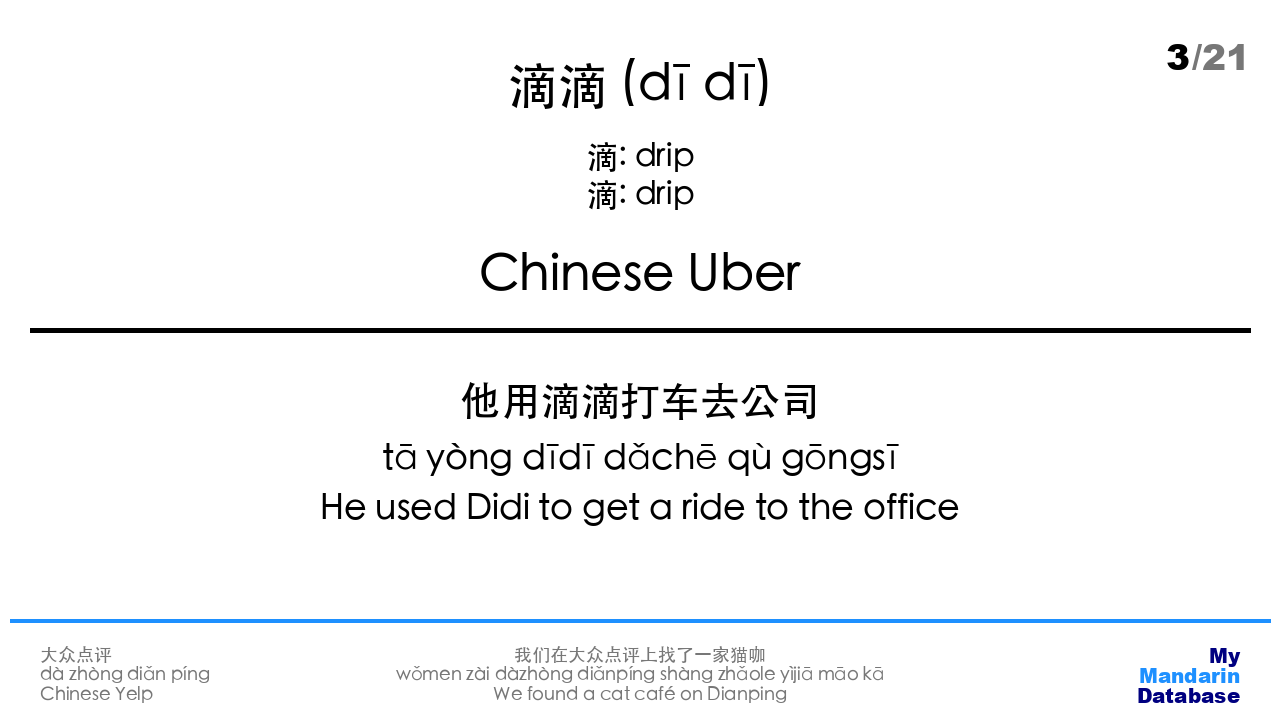

In [12]:
# Overall initializations
clips = []
previous_word = ''
previous_sent = ''

# Create folder to hold slide images
slides_path = f"{project_artifacts_folder}/slides"
if not os.path.exists(slides_path):
    os.mkdir(slides_path)

# Fill in defaults for any missing properties
for config_key, default_config_value in DEFAULT_TEXT_PROPERTIES.items():
    for vocab_slide_id, vocab_slide_settings in video_configs['vocab_slide'].items():
        if config_key not in vocab_slide_settings.keys():
            video_configs['vocab_slide'][vocab_slide_id][config_key] = default_config_value

# Iterate through each word
df_audio_durations_words_only = df_vocab_audio_durations.dropna(subset='sum_theory').reset_index(drop=True)
for word_idx, row in df_audio_durations_words_only.iterrows():
    # Initialize image
    print(f'Drawing {word_idx}: {row["chinese"]}')
    current_image_file_path = f"{slides_path}/{row['chinese']}"
    img = Image.new("RGB", video_configs['bg_size'], color=video_configs['bg_color'])
    draw = ImageDraw.Draw(img)
    
    # Header/Footer texts
    draw_word_index(draw, video_configs, n_vocab, word_idx)
    draw_logo(draw, video_configs)
    draw_previous_word(draw, video_configs, previous_word)
    draw_previous_sent(draw, video_configs, previous_sent)
    draw.line([
        (video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y']),
        (video_configs['bg_size'][0] - video_configs['footer_line']['x'], video_configs['bg_size'][1] - video_configs['footer_line']['y'])],
        fill=video_configs['footer_line']['color'],
        width=video_configs['footer_line']['width'],
        joint=None)
    
    # Update previous
    previous_word = f"{row['chinese']}\n{row['pinyin']}\n{row['english']}"
    if data_settings['recording_id'] in ['013', 'ceword_csent', 'ceword_components_cesent', 'ceword_components_csent']:
        previous_sent = f"{row['sentence']}\n{row['sentence_pinyin']}\n{row['sentence_english']}"

    # Draw vocab depending on recording ID
    draw_vocab_based_on_format(data_settings['recording_id'], row, video_configs, current_image_file_path, img, draw, clips)

clips[11].display_in_notebook()

# 7. Create non-vocab slides


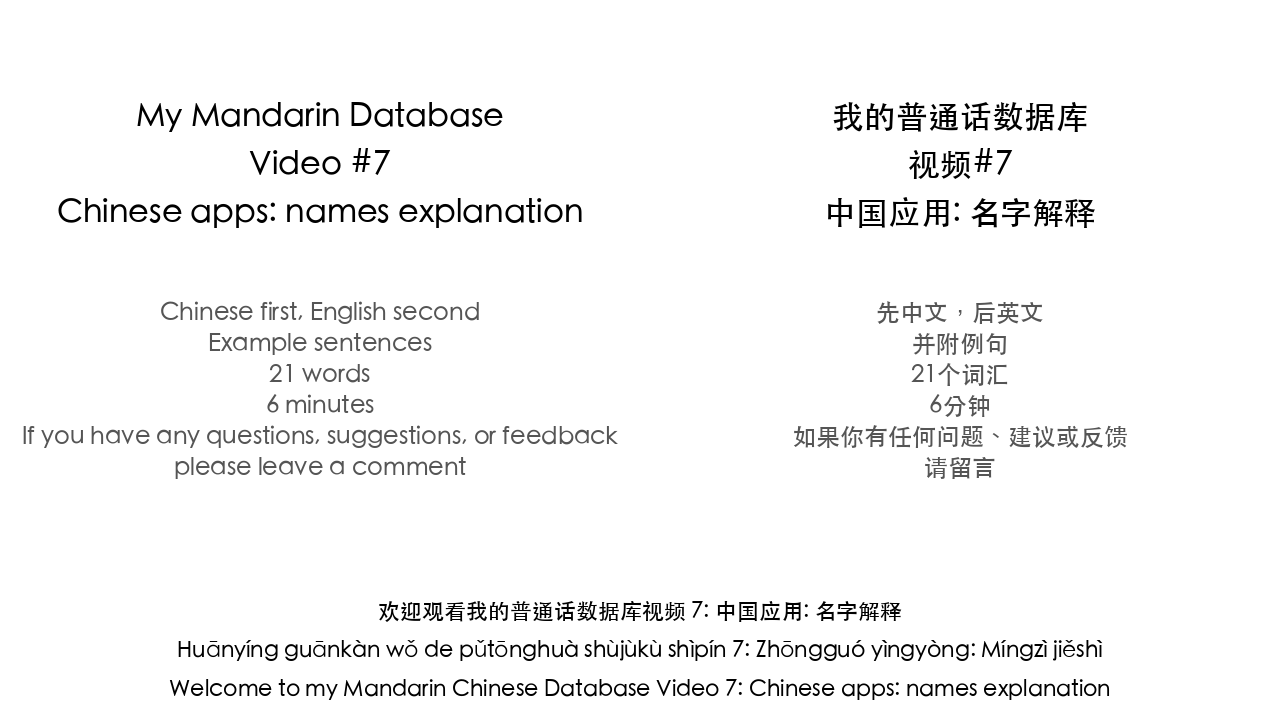

In [13]:
if 'intro' in nonvocab_slides.keys():
    img = generate_intro_slide(video_configs, nonvocab_slides['intro'], subtitle_text_configs, audio_filler_variables)
    img.save(f"{project_artifacts_folder}/intro.png")
my_img = ImageClip(f"{project_artifacts_folder}/intro.png", duration=1).with_start(0)
my_img.display_in_notebook()

"Chinese Google Search" reduced font size to 24
"大众点评" reduced font size to 24
"dà zhòng diǎn píng" reduced font size to 24
"dà zhòng diǎn píng" reduced font size to 22
"dà zhòng diǎn píng" reduced font size to 20
"叮咚买菜" reduced font size to 24
"dīng dōng mǎi cài" reduced font size to 24
"dīng dōng mǎi cài" reduced font size to 22
"高德地图" reduced font size to 24
"京东到家" reduced font size to 24
"jīng dōng dào jiā" reduced font size to 24
"Chinese Grubhub + Yelp" reduced font size to 24
"Chinese Amazon (less variety)" reduced font size to 24
"Chinese Amazon (less variety)" reduced font size to 22
"Chinese Amazon (less variety)" reduced font size to 20
"Chinese Amazon (wider variety)" reduced font size to 24
"Chinese Amazon (wider variety)" reduced font size to 22
"Chinese Amazon (wider variety)" reduced font size to 20
"Chinese Amazon (wider variety)" reduced font size to 18
"携程旅行" reduced font size to 24
"xié chéng lǚ xíng" reduced font size to 24
"Chinese Instagram + Pinterest" reduced f


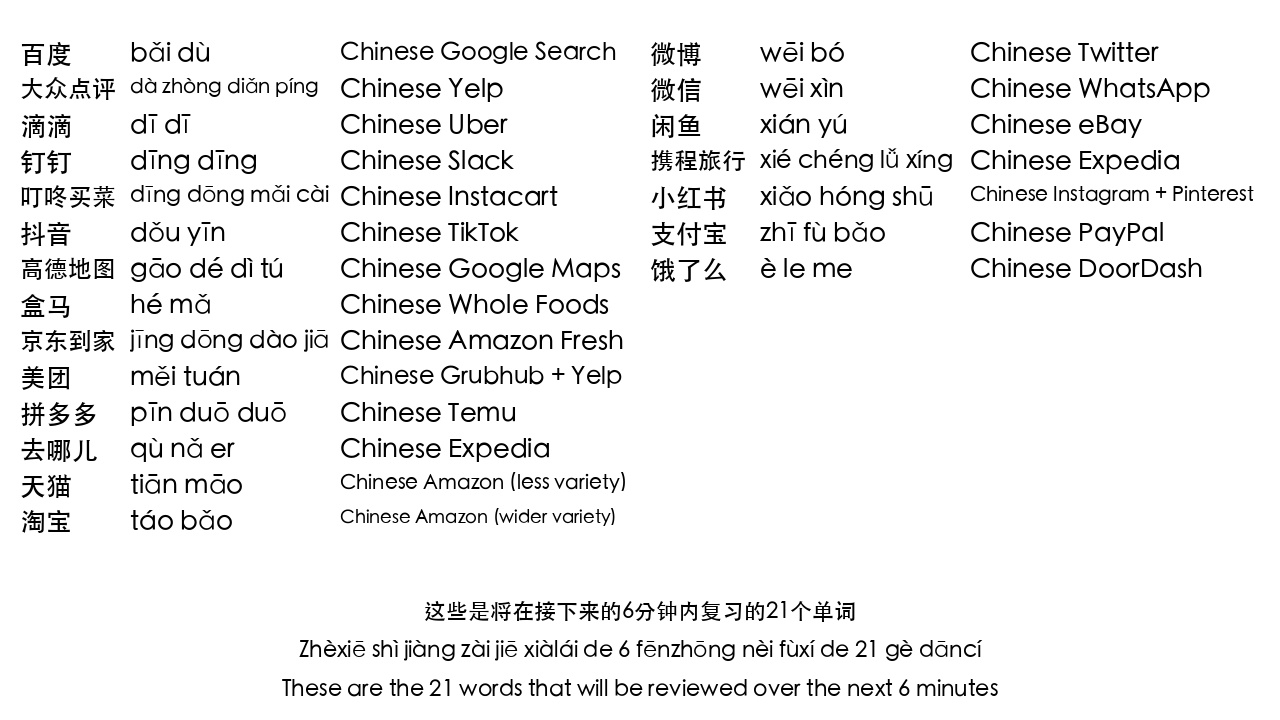

In [14]:
if 'word_list' in nonvocab_slides.keys():
    img = generate_word_list_slide(video_configs, nonvocab_slides['word_list'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/word_list.png")
my_img = ImageClip(f"{project_artifacts_folder}/word_list.png", duration=1).with_start(0)
my_img.display_in_notebook()

"Chinese Google Search" reduced font size to 24
"大众点评" reduced font size to 24
"dà zhòng diǎn píng" reduced font size to 24
"dà zhòng diǎn píng" reduced font size to 22
"dà zhòng diǎn píng" reduced font size to 20
"叮咚买菜" reduced font size to 24
"dīng dōng mǎi cài" reduced font size to 24
"dīng dōng mǎi cài" reduced font size to 22
"高德地图" reduced font size to 24
"京东到家" reduced font size to 24
"jīng dōng dào jiā" reduced font size to 24
"Chinese Grubhub + Yelp" reduced font size to 24
"Chinese Amazon (less variety)" reduced font size to 24
"Chinese Amazon (less variety)" reduced font size to 22
"Chinese Amazon (less variety)" reduced font size to 20
"Chinese Amazon (wider variety)" reduced font size to 24
"Chinese Amazon (wider variety)" reduced font size to 22
"Chinese Amazon (wider variety)" reduced font size to 20
"Chinese Amazon (wider variety)" reduced font size to 18
"携程旅行" reduced font size to 24
"xié chéng lǚ xíng" reduced font size to 24
"Chinese Instagram + Pinterest" reduced f


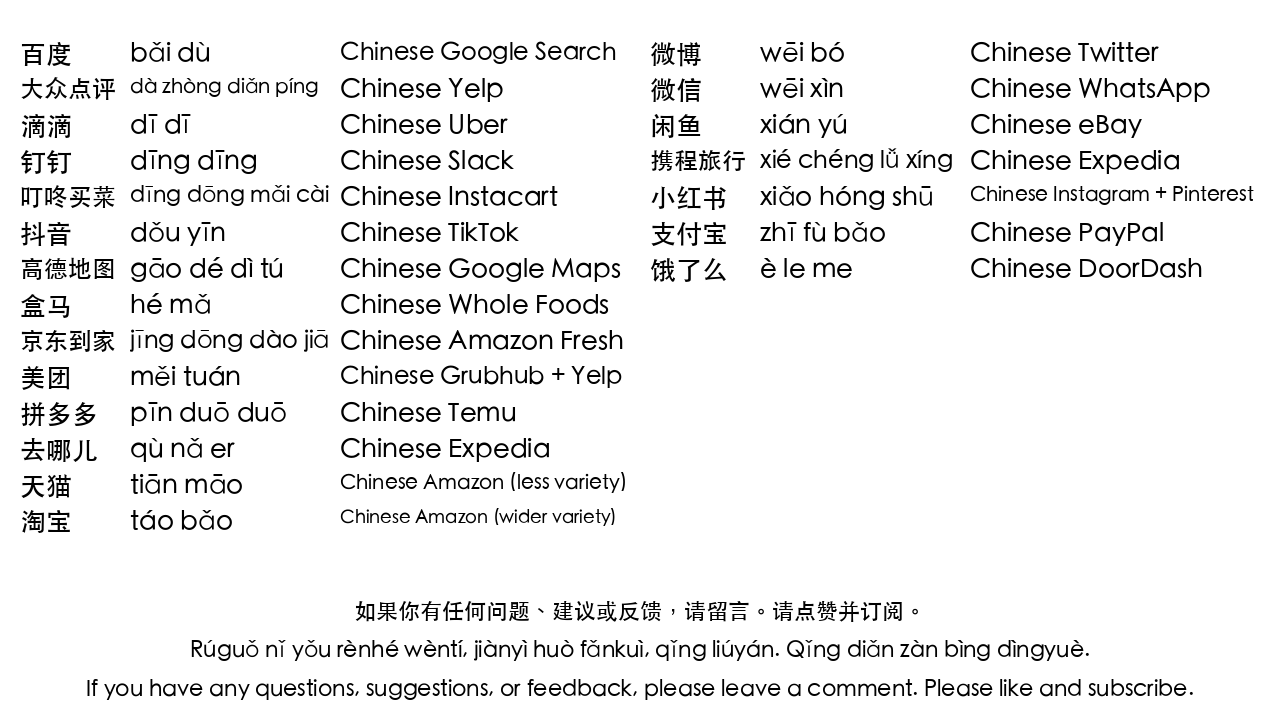

In [15]:
if 'outro' in nonvocab_slides.keys():
    img = generate_outro_slide(video_configs, nonvocab_slides['outro'], subtitle_text_configs, df_audio_durations_words_only)
    img.save(f"{project_artifacts_folder}/outro.png")
my_img = ImageClip(f"{project_artifacts_folder}/outro.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 8. Create video icon


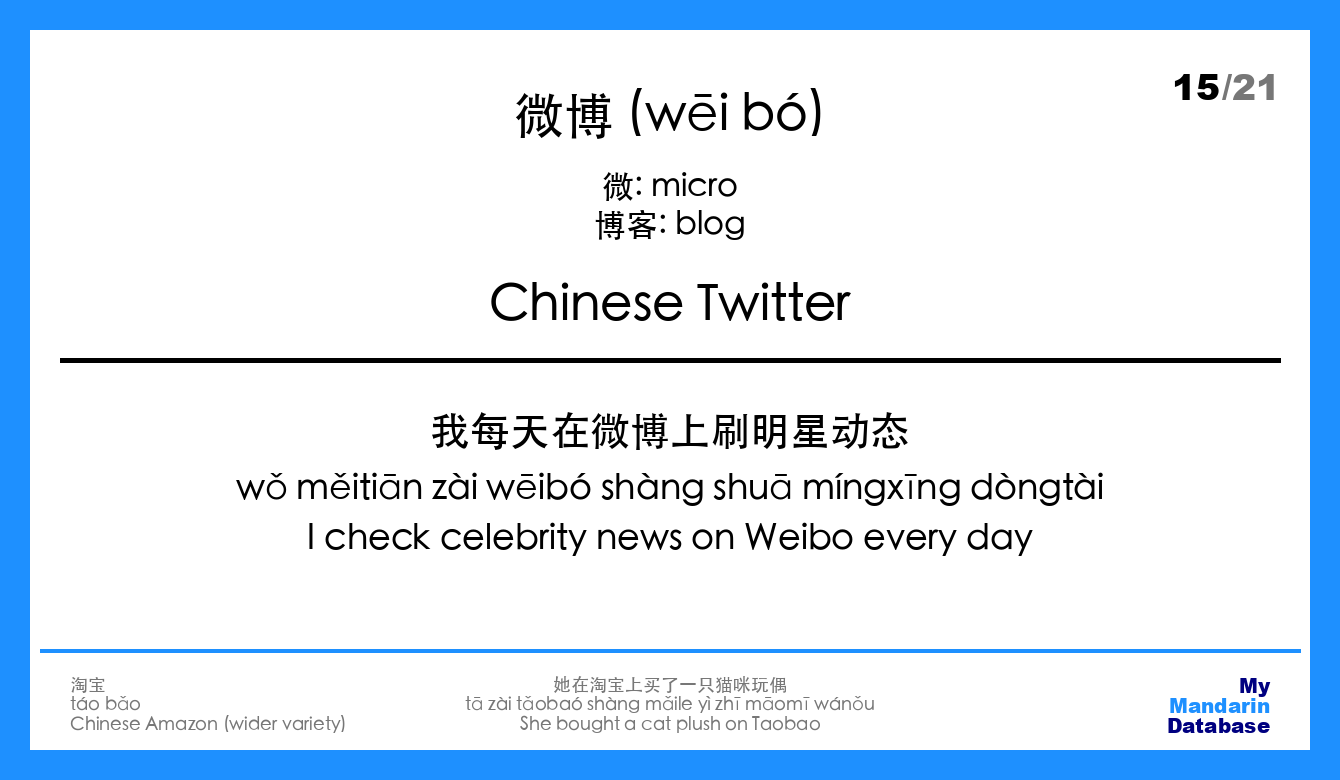

In [16]:
icon_configs['word'] = '微博'
img = create_icon_from_slide(icon_configs, video_configs, project_artifacts_folder)
img.save(f'{project_artifacts_folder}/icon.png')
my_img = ImageClip(f"{project_artifacts_folder}/icon.png", duration=1).with_start(0)
my_img.display_in_notebook()

# 9. Create video

In [17]:
combine_clips_with_audio_to_create_video(clips, nonvocab_slides, project_artifacts_folder)

Number of clips: 87
audio: 375.220s, video: 375.156s; difference: 0.064s
MoviePy - Building video output/videos//0929_ceword_components_csent_app_names/video.mp4.
MoviePy - Writing audio in videoTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
MoviePy - Writing video output/videos//0929_ceword_components_csent_app_names/video.mp4



MoviePy - Done !
MoviePy - video ready output/videos//0929_ceword_components_csent_app_names/video.mp4
